In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

from keras.datasets import mnist

import os
import itertools
from keras.callbacks import ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import io

train = pd.read_csv(F"/content/gdrive/My Drive/MNIST_Datasets/emnist-digits-train.csv" )
test = pd.read_csv(F"/content/gdrive/My Drive/MNIST_Datasets/emnist-digits-test.csv" )

In [4]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Training data size is (239999, 785)
Testing data size is (39999, 785)


In [5]:
#training_digits
y1 = np.array(train.iloc[:,0].values)
x1 = np.array(train.iloc[:,1:].values)
#testing_labels
y2 = np.array(test.iloc[:,0].values)
x2 = np.array(test.iloc[:,1:].values)
print(y1.shape)
print(x1.shape)

(239999,)
(239999, 784)


Visualizing Digit Data - Checking 25 samples

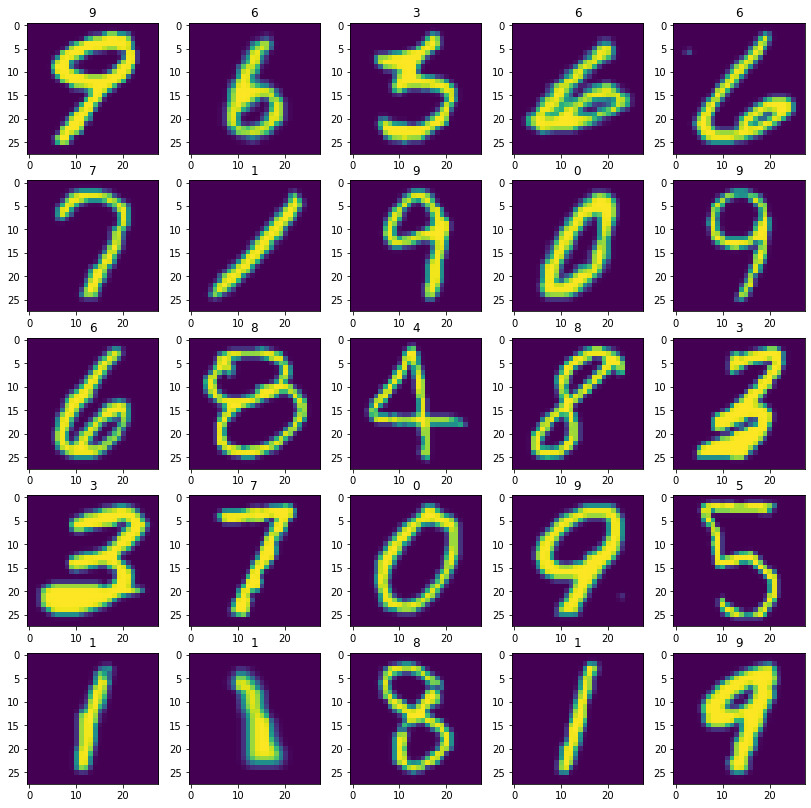

In [6]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

digits = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

fig, axis = plt.subplots(5,5,figsize=(14,14))

for i,ax in enumerate(axis.flat):
    ax.title.set_text(digits[y1[i] - 1])
    ax.imshow(rotate(x1[i]).reshape(28,28))

Normalise & Reshape Images

In [7]:
# Normalise and reshape data
train_images = x1 / 255.0
test_images = x2 / 255.0

train_images_number = train_images.shape[0]
train_images_height = 28
train_images_width = 28
train_images_size = train_images_height*train_images_width

train_images = train_images.reshape(train_images_number, train_images_height, train_images_width, 1)

test_images_number = test_images.shape[0]
test_images_height = 28
test_images_width = 28
test_images_size = test_images_height*test_images_width

test_images = test_images.reshape(test_images_number, test_images_height, test_images_width, 1)

Check Class Count

In [8]:
np.unique(y1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Label Transform

In [9]:
number_of_classes = 10

y1 = tf.keras.utils.to_categorical(y1, number_of_classes)
y2 = tf.keras.utils.to_categorical(y2, number_of_classes)

Callback API to save best weights and change learning rate
W/ early stopping & LR reduction

In [10]:
#--- Model Checkpoint
MCP = ModelCheckpoint('Best_points.h5', verbose = 1, save_best_only = True, monitor = 'val_accuracy', mode = 'max')

#--- Early Stopping
ES = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, verbose = 0, restore_best_weights = True, patience = 3, mode = 'max')

#--- Learning rate reduction upon plateau
RLP = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 0.2, min_lr = 0.0001)

In [11]:
train_x, test_x, train_y, test_y, = train_test_split(train_images, y1, test_size=0.2, random_state = 42)

Convolutional Neural Network 
DigitNet Model

In [12]:
model=Sequential()
  
model.add(Conv2D(filters=32, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())  
model.add(Dropout(0.25))  

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10,activation="softmax"))

Compile model

In [13]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Summary to View Model Parameters & Output Shape

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          3

Train Model - Without Data Augmentation

In [ ]:
#--- With earlystopping Callbacks
history = model.fit(train_x, train_y, epochs = 1,
                    validation_data = (test_x, test_y),
                    callbacks=[MCP, ES, RLP])

#--- Without Earlystopping Callbacks
#history = model.fit(train_x, train_y, epochs = 30,
#                    validation_data = (test_x, test_y))

# loss_accuracy
loss, accuracy = model.evaluate(test_x, test_y, verbose = False)

Plot Training Loss & Validation Curves

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Test Metrics

In [18]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [ ]:
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Plot Testing Curves

In [ ]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
fig

Training Model With Data Augmentation

In [21]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  
        
epochs = 30
batch_size = 32

train_gen = datagen.flow(train_x, train_y, batch_size=batch_size)
test_gen = datagen.flow(test_x, test_y, batch_size=batch_size)

In [ ]:
history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_x.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = test_x.shape[0] // batch_size,
                              callbacks=[MCP])

# loss_accuracy
loss, accuracy = model.evaluate(test_x, test_y, verbose = False)

Plot Training Loss & Validation Curves

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Test Metrics

In [ ]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [ ]:
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Plot Test Curves

In [ ]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
fig

# Saving Models
Bypass ModelCheckPoint

In [ ]:
!mkdir -p saved_model
model.save('saved_model/digit_model.h5') 

In [ ]:
!ls saved_model/

!ls saved_model/digit_model.h5